<a href="https://colab.research.google.com/github/JhulianaM/Mammography/blob/master/From0Edsr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Paso 1: Subir el archivo kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhulianamercado","key":"a71185f6733aa19acf1b25c0137bd4ea"}'}

In [2]:
# Paso 2: Configurar Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Paso 3: Descargar el Dataset de Kaggle
!kaggle datasets download -d kmader/mias-mammography
!unzip mias-mammography.zip -d mias-mammography

Dataset URL: https://www.kaggle.com/datasets/kmader/mias-mammography
License(s): other
 99% 307M/312M [00:04<00:00, 81.5MB/s]
100% 312M/312M [00:04<00:00, 79.2MB/s]
Archive:  mias-mammography.zip
  inflating: mias-mammography/Info.txt  
  inflating: mias-mammography/all-mias.tar.gz  
  inflating: mias-mammography/all-mias/Info.txt  
  inflating: mias-mammography/all-mias/Licence.txt  
  inflating: mias-mammography/all-mias/README  
  inflating: mias-mammography/all-mias/mdb001.pgm  
  inflating: mias-mammography/all-mias/mdb002.pgm  
  inflating: mias-mammography/all-mias/mdb003.pgm  
  inflating: mias-mammography/all-mias/mdb004.pgm  
  inflating: mias-mammography/all-mias/mdb005.pgm  
  inflating: mias-mammography/all-mias/mdb006.pgm  
  inflating: mias-mammography/all-mias/mdb007.pgm  
  inflating: mias-mammography/all-mias/mdb008.pgm  
  inflating: mias-mammography/all-mias/mdb009.pgm  
  inflating: mias-mammography/all-mias/mdb010.pgm  
  inflating: mias-mammography/all-mias/mdb01

In [3]:
import cv2
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_images(path, img_size=(256, 256)):
    images = []
    for img_path in glob.glob(path + '/*.pgm'):
        img = load_img(img_path, color_mode='grayscale', target_size=img_size)
        img = img_to_array(img)
        img = img / 255.0  # Normalizar
        images.append(img)
    return np.array(images)

# Cargar las imágenes
images_path = './mias-mammography/all-mias'
images = load_images(images_path)

# Crear imágenes de baja resolución
def create_low_res_images(images, scale=2):
    low_res_images = []
    for img in images:
        low_res_img = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_AREA)
        low_res_img = cv2.resize(low_res_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
        low_res_images.append(low_res_img)
    return np.array(low_res_images)

low_res_images = create_low_res_images(images)

# División de datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(low_res_images, images, test_size=0.2, random_state=42)


In [4]:
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def edsr(scale, num_filters=64, num_res_blocks=8):
    def res_block(x):
        res = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(x)
        res = Conv2D(num_filters, kernel_size=3, padding='same')(res)
        return Add()([x, res])

    input_layer = Input(shape=(None, None, 1))
    x = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(input_layer)

    for _ in range(num_res_blocks):
        x = res_block(x)

    x = Conv2D(1, kernel_size=3, padding='same')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

# Crear el modelo EDSR
scale = 2
model = edsr(scale)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 64)       36928     ['conv2d_1[0][0]']            
                                                                                              

In [5]:
'''from tensorflow.keras.layers import Input, Conv2D, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def edsr(scale, num_filters=128, num_res_blocks=16, dropout_rate=0.5):
    def res_block(x):
        res = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(x)
        res = Dropout(dropout_rate)(res)
        res = Conv2D(num_filters, kernel_size=3, padding='same')(res)
        return Add()([x, res])

    input_layer = Input(shape=(None, None, 1))
    x = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(input_layer)

    for _ in range(num_res_blocks):
        x = res_block(x)

    x = Conv2D(1, kernel_size=3, padding='same')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

# Crear el modelo EDSR con más filtros y bloques residuales, y dropout
scale = 2
model = edsr(scale)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])
model.summary()'''


"from tensorflow.keras.layers import Input, Conv2D, Add, Dropout\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.optimizers import Adam\n\ndef edsr(scale, num_filters=128, num_res_blocks=16, dropout_rate=0.5):\n    def res_block(x):\n        res = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(x)\n        res = Dropout(dropout_rate)(res)\n        res = Conv2D(num_filters, kernel_size=3, padding='same')(res)\n        return Add()([x, res])\n\n    input_layer = Input(shape=(None, None, 1))\n    x = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(input_layer)\n\n    for _ in range(num_res_blocks):\n        x = res_block(x)\n\n    x = Conv2D(1, kernel_size=3, padding='same')(x)\n    model = Model(inputs=input_layer, outputs=x)\n    return model\n\n# Crear el modelo EDSR con más filtros y bloques residuales, y dropout\nscale = 2\nmodel = edsr(scale)\nmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', 

Epoch 1/50
17/17 [==============================] - 27s 934ms/step - loss: 3.1304 - accuracy: 0.4853 - val_loss: 0.0035 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 15s 885ms/step - loss: 0.0031 - accuracy: 0.4881 - val_loss: 0.0012 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 15s 899ms/step - loss: 8.0392e-04 - accuracy: 0.4881 - val_loss: 6.3837e-04 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 15s 912ms/step - loss: 4.8536e-04 - accuracy: 0.4881 - val_loss: 9.9577e-04 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 16s 938ms/step - loss: 6.3840e-04 - accuracy: 0.4881 - val_loss: 5.7157e-04 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 16s 925ms/step - loss: 4.1043e-04 - accuracy: 0.4881 - val_loss: 2.8561e-04 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 16s 915ms/step - loss: 2.8480e-04 - accuracy: 0.4881 - val_loss: 2.6891e-04 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 8/50
17/17 [=================

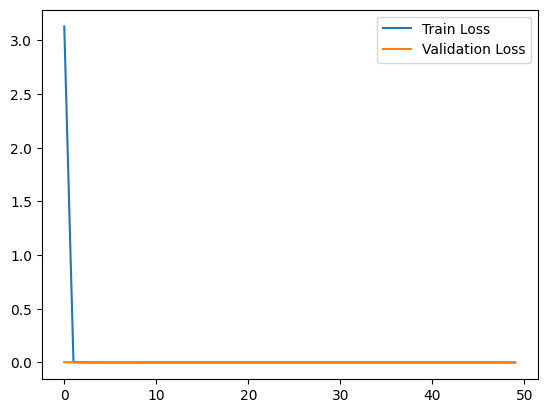

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Callbacks para el entrenamiento
checkpoint = ModelCheckpoint('edsr_mias.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Entrenamiento del modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=16, callbacks=[checkpoint, reduce_lr])

# Visualización de la curva de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
